# Majorana nanowire conductance, band structure, phase diagram, and wave function

In [7]:
import numpy as np
import kwant
from scipy.constants import hbar, m_e, eV, physical_constants
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.size"] = 20

meV = eV * 1e-3  # one meV in J
mu_B = physical_constants["Bohr magneton"][0] / meV  # Bohr magneton in meV
g = 50
m = 0.015 * m_e  # the effective mass in kg
a = 5  # the lattice spacing in nm
t = (hbar ** 2 / (2 * m * a ** 2)) * (1e18 / meV)  # meV

s0 = np.array([[1.0, 0.0], [0.0, 1.0]])
sx = np.array([[0.0, 1.0], [1.0, 0.0]])
sy = np.array([[0.0, -1j], [1j, 0.0]])
sz = np.array([[1.0, 0.0], [0.0, -1.0]])

# Tunnel spectroscopy
# the system will consist of three subsystems
# We apply a magnetic field in all parts of the system
def onsite_sc(site, mu_sc, B_x, delta):
    return (
        (-2 * t + mu_sc) * np.kron(s0, sz)
        + (0.5 * B_x * g * mu_B) * np.kron(sx, s0)
        + delta * np.kron(s0, sx)
    )


def onsite_normal(site, mu_l, B_x):
    return (-2 * t + mu_l) * np.kron(s0, sz) + (0.5 * B_x * g * mu_B) * np.kron(sx, s0)


def onsite_barrier(site, mu_l, B_x, Vbarrier):
    return (-2 * t + mu_l - Vbarrier) * np.kron(s0, sz) + (
        0.5 * B_x * g * mu_B
    ) * np.kron(sx, s0)


# The hopping is the same in all subsystems. There is normal hopping and
# spin orbit interaction.
def hop(site1, site2, alpha):
    return t * np.kron(s0, sz) + 0.5j * alpha / a * np.kron(sy, sz)


def make_system_spectroscopy(t=t, a=a):
    lat = kwant.lattice.chain(a=a, norbs=4)
    sys = kwant.Builder()

    # The first subsystem just consists of the tunnel barrier (one site with a
    # potential)
    sys[lat(0)] = onsite_barrier

    # The second subsystem is a normal lead
    # The translational symmetry makes it semiinfinite.
    symmetry = kwant.TranslationalSymmetry(*lat.prim_vecs)
    lead_normal = kwant.Builder(symmetry, conservation_law=-np.kron(s0, sz))
    # Define a unit cell (in this case the unitcell consists of a single site)
    lead_normal[lat(0)] = onsite_normal
    # Define the hopping between unitcells
    lead_normal[lat(1), lat(0)] = hop

    # The third subsystem is a superconducting lead. A Majorana bound state
    # can arise at the edge of this system.
    lead_sc = kwant.Builder(symmetry)
    # Again: Define a unitcell
    lead_sc[lat(0)] = onsite_sc
    # Again define hopping between unitcells
    lead_sc[lat(1), lat(0)] = hop

    # Create a connection between the first subsystem (the tunnelbarrier, system name: sys)
    # and the other two subsystems (the normal and the superconducting lead)
    sys.attach_lead(lead_normal)
    sys.attach_lead(lead_sc)

    sys = sys.finalized()

    return sys


def make_majorana_nanowire(
    t=t, a=a, L=100, as_lead=False, finalize=True, n_cells_in_unit_cell=1
):
    lat = kwant.lattice.chain(a=a, norbs=4)
    symmetry = (
        kwant.TranslationalSymmetry([n_cells_in_unit_cell * a]) if as_lead else None
    )
    sys = kwant.Builder(symmetry)
    sys[(lat(i) for i in range(L // a))] = onsite_sc
    sys[lat.neighbors()] = hop
    if finalize:
        sys = sys.finalized()
    return sys


def tunnel_spectroscopy(params):
    sys = make_system_spectroscopy()
    Es = np.linspace(-1.2 * params["delta"], 1.2 * params["delta"], 51) + 1e-5
    Gs = []
    for E in Es:
        # This function returns the scatering matrix (at the energy given by the second argument)
        # of the system. The scattering matrix holds the information about
        # conductivity.
        smat = kwant.smatrix(sys, energy=E, params=params)
        Andreev_conductance = (
            smat.submatrix((0, 0), (0, 0)).shape[0]
            - smat.transmission((0, 0), (0, 0))
            + smat.transmission((0, 1), (0, 0))
        )
        Gs.append(Andreev_conductance)

    return Es, Gs


def majorana_size_from_modes(lead, params):
    """Find the slowest decaying (evanescent) mode and returns the
    Majorana size.

    It uses an adapted version of the function kwant.physics.leads.modes,
    in such a way that it returns the eigenvalues of the translation operator
    (lamdba = |r|*e^ik). The imaginary part of the wavevector k, is the part
    that makes it decay. The inverse of this Im(k) is the size of a Majorana
    bound state. The norm of the eigenvalue that is closest to one is the
    slowest decaying mode. Also called decay length.

    Parameters:
    -----------
    lead : kwant.builder.InfiniteSystem object
        The finalized infinite system.

    Returns:
    --------
    majorana_length : float
        The length of the Majorana.
    """
    h = lead.cell_hamiltonian(params=params)
    t = lead.inter_cell_hopping(params=params)
    a, b = kwant.physics.leads.setup_linsys(h, t, 1e6, None).eigenproblem
    ev = kwant.physics.leads.unified_eigenproblem(a, b, tol=1e6)[0]
    norm = ev * ev.conj()
    idx = np.abs(norm - 1).argmin()
    a = lead.sites[0].family.prim_vecs[0]
    majorana_length = np.abs(a / np.log(ev[idx]).real)
    return float(majorana_length)


def plot_spectroscopy(mu_l, mu_sc, B_x, alpha, delta, Vbarrier):
    fig, ax = plt.subplots()
    params = dict(
        mu_l=mu_l, mu_sc=mu_sc, B_x=B_x, alpha=alpha, delta=delta, Vbarrier=Vbarrier
    )
    # Trivial, because the magnetic field is zero (third argument)
    Es, Gs = tunnel_spectroscopy(dict(params, B_x=0))
    ax.plot(Es, Gs, "k-", label="trivial")

    # Non-trivial
    Es, Gs = tunnel_spectroscopy(params)
    ax.plot(Es, Gs, "r-", label="non trivial")

    ax.set_title("Tunnel spectroscopy")
    ax.set_xlabel("Bias Voltage")
    ax.set_xlim([-1.2 * delta, 1.2 * delta])
    ax.set_ylabel("$G/G_0$")
    ax.set_ylim([-0.0, 2.1])

    ax.legend(fontsize=7)

    return fig


def plot_bandstructure(mu_l, mu_sc, B_x, alpha, delta, show_gap, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    params = dict(
        mu_l=mu_l, mu_sc=mu_sc, B_x=B_x, alpha=alpha, delta=delta, Vbarrier=None
    )
    ks = np.linspace(-np.pi / 4, np.pi / 4, 201)
    lead = make_system_spectroscopy().leads[1]
    bands = kwant.physics.Bands(lead, params=params)
    Es = [bands(k) for k in ks]
    ax.plot(ks, Es, "k-")

    ax.set_xlabel(r"$k_x \; [\textrm{nm}^{-1}]$")
    ax.set_ylabel(r"$E \; [\textrm{meV}]$")
    ax.set_title(rf"\textrm{{Topological band structure}}")
    ax.set_xticks([-np.pi / 4, 0, np.pi / 4])
    ax.set_xticklabels(["$-\pi/4$", "$0$", "$\pi/4$"])
    yticks = [-2, 0, 2]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"${y}$" for y in yticks])
    ax.set_ylim(yticks[0]-0.1, yticks[-1]+0.1)
    if show_gap:
        E_gap = np.abs(Es).min()
        x_right = ks[-1] / 2
        x_left = ks[0]
        ax.hlines(E_gap, x_left, ks[-1], linestyles="--", colors="r")
        ax.hlines(0, x_left, x_right, linestyles="--", colors="k")
        ax.hlines(-E_gap, x_left, ks[-1], linestyles="--", colors="r")
        ax.annotate(r"$2E_\textrm{gap}$", (x_right + 0.05, 0), va="center", ha="left")
        props = dict(
            head_width=0.1,
            head_length=0.15,
            overhang=0.4,
            color="k",
            length_includes_head=True,
        )
        ax.arrow(x_right, 0, dx=0, dy=E_gap, **props)
        ax.arrow(x_right, 0, dx=0, dy=-E_gap, **props)
    return fig


def plot_wavefunction(
    mu_sc=10, B_x=1, alpha=50, delta=1, L=300, a=5, calc_xi_M=False, ax=None, fig=None
):
    params = dict(mu_sc=mu_sc, B_x=B_x, alpha=alpha, delta=delta, L=L)
    syst = make_majorana_nanowire(L=L, a=a)
    ham = syst.hamiltonian_submatrix(params=dict(params))
    energies, wfs = np.linalg.eigh(ham)
    i_min = np.abs(energies).argmin()
    rho = kwant.operator.Density(syst)
    wf = rho(wfs[:, i_min])
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(wf)
    ax.set_xlabel(r"$L \; \textrm{[nm]}$")
    ax.set_ylabel(r"$\left| \Psi_\textrm{M} \right|^2$")
    xticks = [0, L / a // 2, L / a]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"${a*x}$" for x in xticks])
    yticks = [0, round(wf.max() + 5e-3, 2)]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"${y}$" for y in yticks])

    title = rf"\textrm{{Majorana wave function}}"
    if calc_xi_M:
        lead = make_system_spectroscopy(t=t, a=a).leads[1]
        xi_M = majorana_size_from_modes(lead, params)
        title += fr', $\xi_{{\textrm{{M}}}}={xi_M:.1f} \; \textrm{{nm}}$'
        i_max = np.argmax(wf[: len(wf) // 2])
        ax.annotate(
            s=r"",
            xy=(i_max, wf[i_max]),
            xytext=(i_max + xi_M / a, wf[i_max]),
            arrowprops=dict(arrowstyle="<->"),
            ha="center",
            va="center",
        )
        ax.annotate(
            s=r"$\xi_{\textrm{M}}$",
            xy=(i_max + xi_M / a / 2, wf[i_max]),
            xycoords="data",
            xytext=(0, 2),
            textcoords="offset points",
            ha="center",
            va="bottom",
        )
        ax.vlines(i_max, 0, 0.03, linestyles="--")
        ax.vlines(i_max + xi_M / a, 0, 0.03, linestyles="--")

    ax.set_title(title)
    return fig


def plot_phase_transition(delta, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(r"$\textrm{Majorana phase diagram}$")
    ax.set_xlabel(r"$B_x \; \textrm{[T]}$")
    ax.set_ylabel(r"$\mu \; \textrm{[meV]}$")
    B_xs = np.linspace(0, 2, 2000)
    ax.set_xlim(0, B_xs[-1])

    def phase_transition(B_x, delta):
        E_z = 0.5 * g * mu_B * B_x
        mu = np.sqrt(E_z ** 2 - delta ** 2)
        return np.vstack([mu, -mu]).T

    boundary = phase_transition(B_xs, delta)
    ax.plot(B_xs, boundary, c="C1")
    trivial = np.isnan(boundary[:, 0])
    ax.fill_between(
        B_xs[~trivial],
        boundary[~trivial, 0],
        boundary[~trivial, 1],
        color="C2",
        label="topological",
    )
    ax.fill_between([0, 1e-3], 0.0, 1e-3, color="white", label="trivial")
    ax.legend(loc="upper left", facecolor="grey", framealpha=0.2)
    return fig

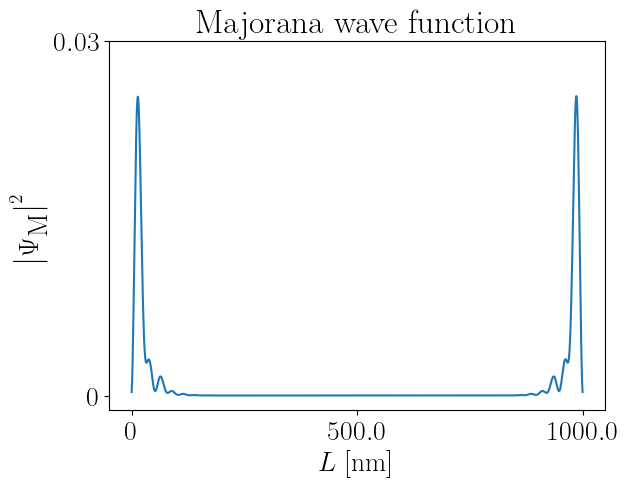

In [13]:
# plot wavefunctions
plot_wavefunction(mu_sc=0,B_x=0.7,alpha=50, delta = 0.5, L=1000, a=1);

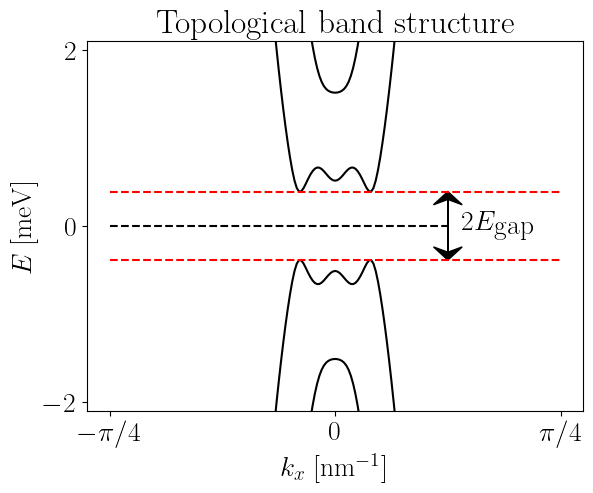

In [16]:
plot_bandstructure(mu_l=25,mu_sc=0,B_x=0.7,alpha=50,delta=0.5,show_gap=True);

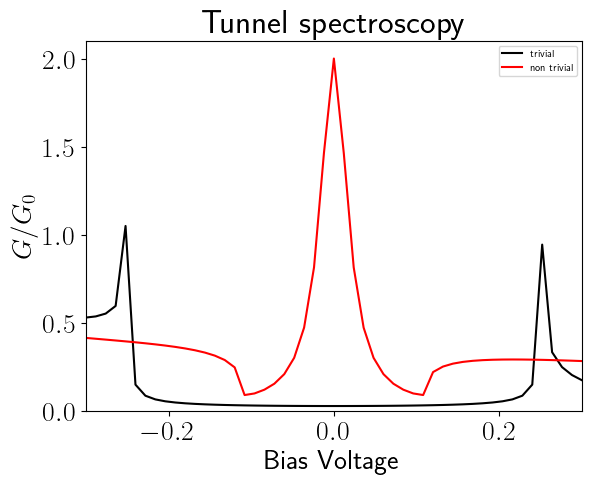

In [17]:
plot_spectroscopy(mu_l=15,mu_sc=0,B_x=0.5,alpha=20,delta=0.25,Vbarrier=50);

C:\Users\chenx\AppData\Local\Temp\ipykernel_43544\3287434516.py:278: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(E_z ** 2 - delta ** 2)


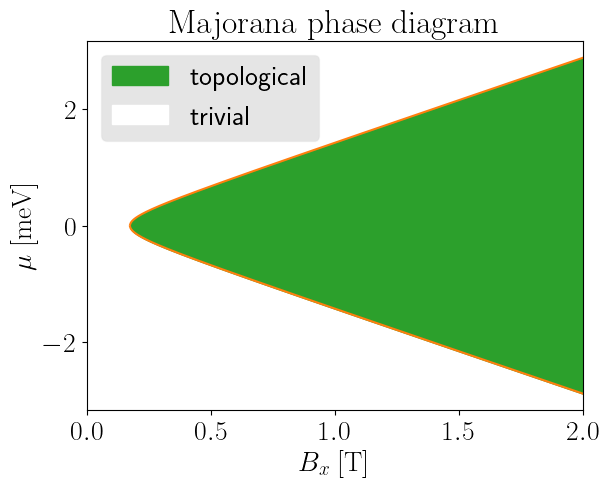

In [20]:
plot_phase_transition(delta=0.25);

C:\Users\chenx\AppData\Local\Temp\ipykernel_43544\3287434516.py:278: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(E_z ** 2 - delta ** 2)


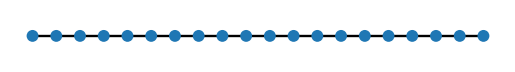

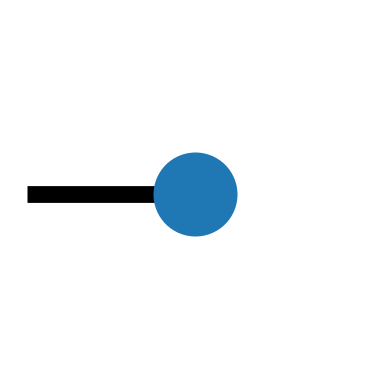

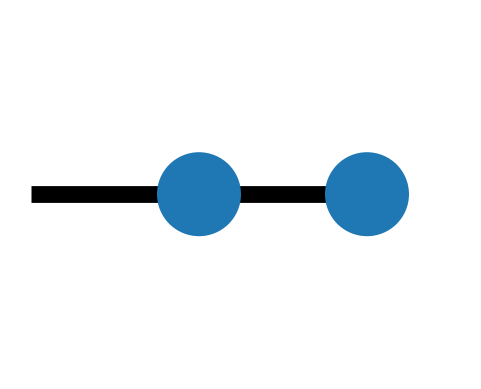

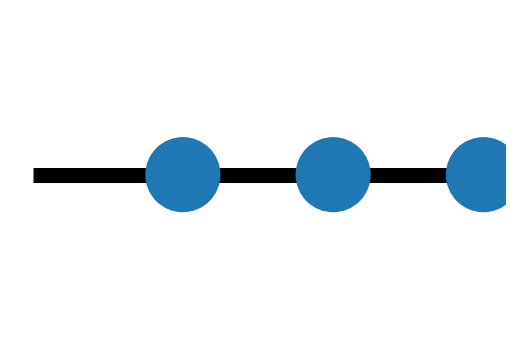

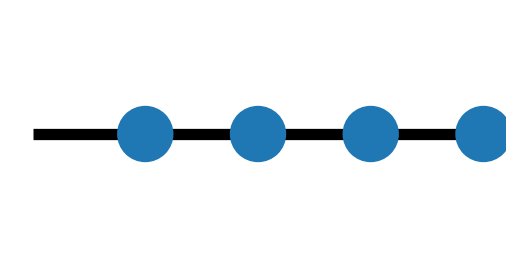

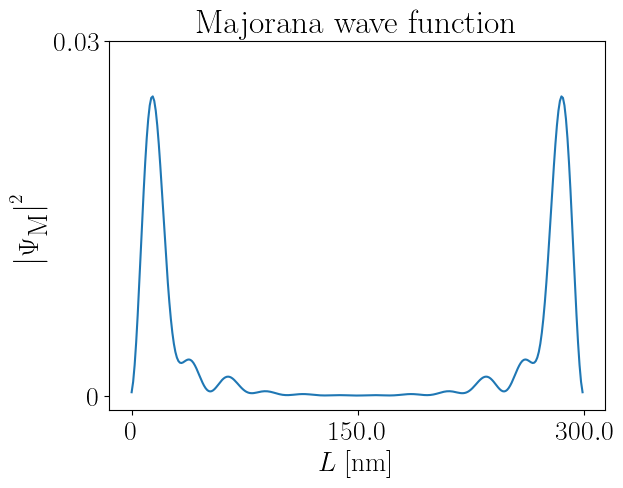

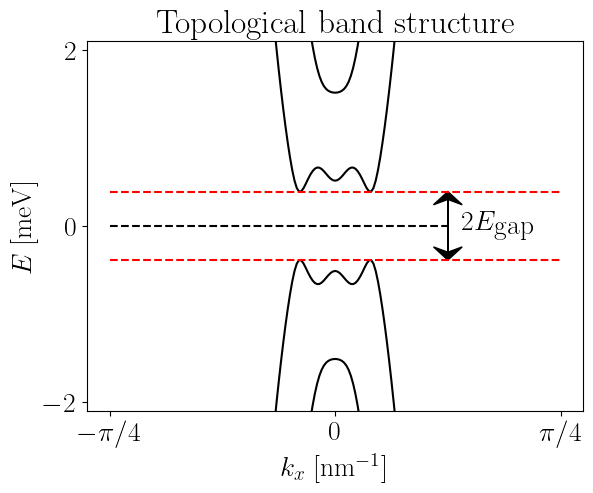

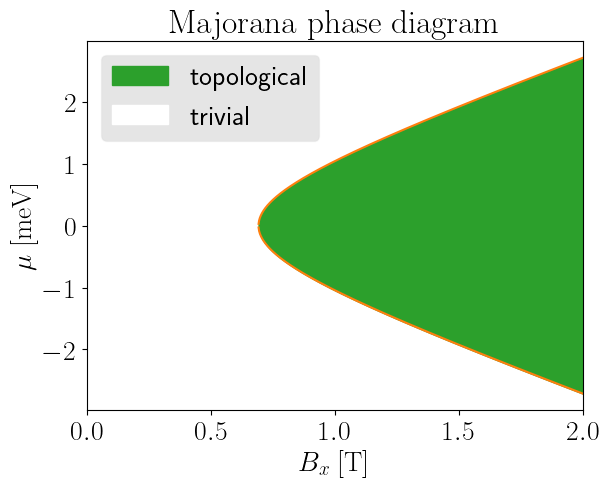

In [22]:
# Saving some plots for a presentation
f = kwant.plot(make_majorana_nanowire(L=100), show=False)
ax, = f.get_axes()
plt.axis('off')
f.savefig('finite_system.pdf', bbox_inches='tight')
for i in range(1, 5):
    f = kwant.plot(make_majorana_nanowire(L=5*i, as_lead=True,
        finalize=False, n_cells_in_unit_cell=i), show=False)
    plt.axis('off')
    f.savefig(f'infinite_system_{i}.pdf', bbox_inches='tight')
f = plot_wavefunction(mu_sc=0, B_x=0.7, alpha=50, delta=0.50, L=300, a=1, calc_xi_M=False)
f.savefig('wf.pdf', bbox_inches='tight')
f = plot_bandstructure(mu_l=25, mu_sc=0, B_x=0.7, alpha=50, delta=0.50, show_gap=True)
f.savefig('band_structure.pdf', bbox_inches='tight')
f = plot_phase_transition(1)
f.savefig('phase_diagram_1D.pdf', bbox_inches='tight')

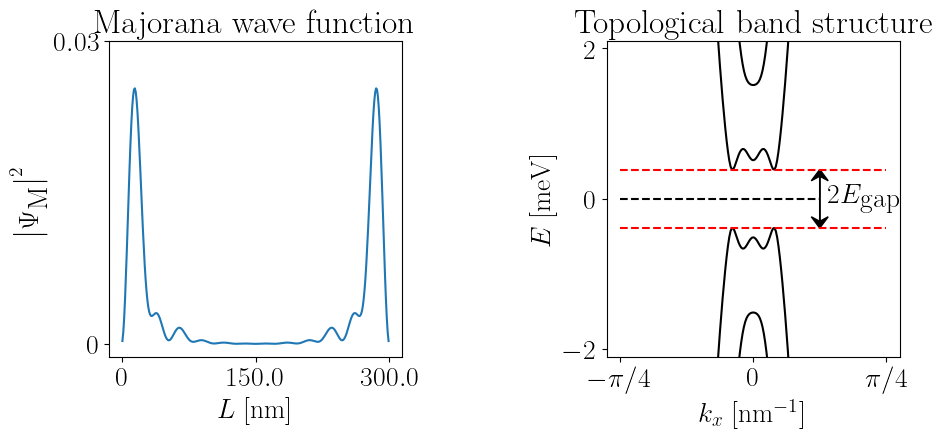

In [24]:
fig, axs = plt.subplots(ncols=2, figsize=(3*3.40, 4.10))
plt.subplots_adjust(wspace=0.7)
f = plot_wavefunction(mu_sc=0, B_x=0.7, alpha=50, delta=0.50, L=300, a=1, calc_xi_M=False, ax=axs[0], fig=fig)
f = plot_bandstructure(mu_l=25, mu_sc=0, B_x=0.7, alpha=50, delta=0.50, show_gap=True, ax=axs[1], fig=fig)
f.savefig('wf.pdf', bbox_inches='tight')